<a href="https://colab.research.google.com/github/moqimoqidea/moqi/blob/master/gpu_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 验证当前环境是否支持GPU

In [ ]:
!nvidia-smi

Sun Mar 10 05:14:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              27W /  70W |    109MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 安装 Numba 库

In [ ]:
!pip install numba

# GPU Version

Optimized GPU computation time: 0.19307708740234375 seconds


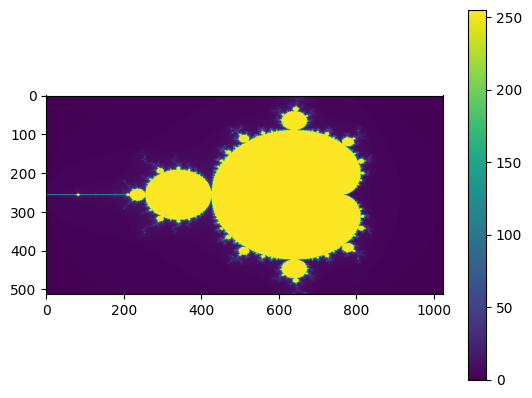

Total runtime after optimization: 0.4682044982910156 seconds


In [ ]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import time

@cuda.jit
def mandelbrot_kernel(min_x, max_x, min_y, max_y, image, iters):
    height, width = image.shape
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    # 线程ID和总线程数
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y

    # 每个线程计算多个点
    for x in range(startX, width, gridX):
        real = min_x + x * pixel_size_x
        for y in range(startY, height, gridY):
            imag = min_y + y * pixel_size_y
            c = complex(real, imag)
            z = 0.0j
            for i in range(iters):
                z = z*z + c
                if (z.real * z.real + z.imag * z.imag) >= 4:
                    image[y, x] = i
                    break
            else:
                image[y, x] = iters - 1

def compute_mandelbrot(min_x, max_x, min_y, max_y, image, iters=256):
    # 调整blockdim和griddim来匹配GPU特性和问题大小
    blockdim = (16, 16)
    griddim = (32, 32)

    d_image = cuda.to_device(image)
    start_time = time.time()
    mandelbrot_kernel[griddim, blockdim](min_x, max_x, min_y, max_y, d_image, iters)
    cuda.synchronize()
    end_time = time.time()
    print(f"Optimized GPU computation time: {end_time - start_time} seconds")

    d_image.copy_to_host(ary=image)

def main():
    width = 1024
    height = 512
    image = np.zeros((height, width), dtype=np.uint8)
    min_x, max_x = -2.0, 1.0
    min_y, max_y = -1.0, 1.0

    compute_mandelbrot(min_x, max_x, min_y, max_y, image, 256)

    plt.imshow(image)
    plt.colorbar()
    plt.show()

if __name__ == '__main__':
    main_start_time = time.time()
    main()
    main_end_time = time.time()
    print(f"Total runtime after optimization: {main_end_time - main_start_time} seconds")

# CPU Version

Starting CPU computation...
CPU computation time: 0.5535924434661865 seconds


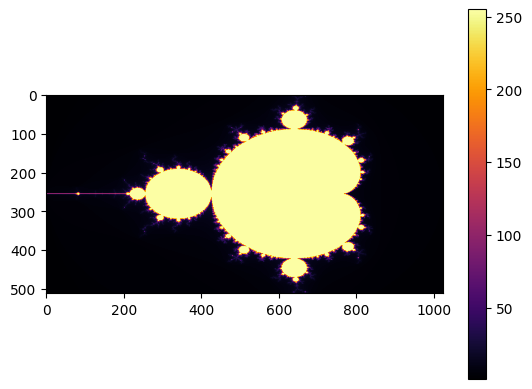

Total runtime: 0.8336484432220459 seconds


In [ ]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import time

@jit(nopython=True)
def mandelbrot(x, y, max_iters):
    """计算给定坐标的Mandelbrot集归属，并返回迭代次数。"""
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
        z = z*z + c
    return max_iters - 1

@jit(nopython=True)
def compute_mandelbrot(min_x, max_x, min_y, max_y, width, height, iters):
    """为整个图像生成Mandelbrot集。"""
    result = np.zeros((height, width), dtype=np.uint8)
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandelbrot(real, imag, iters)
            result[y, x] = color
    return result

def main():
    """主函数，设置参数，计算Mandelbrot集，测量时间，显示结果。"""
    min_x, max_x = -2.0, 1.0
    min_y, max_y = -1.0, 1.0
    width, height = 1024, 512
    iters = 256

    print("Starting CPU computation...")
    start_time = time.time()
    image = compute_mandelbrot(min_x, max_x, min_y, max_y, width, height, iters)
    end_time = time.time()
    print(f"CPU computation time: {end_time - start_time} seconds")

    plt.imshow(image, cmap="inferno")
    plt.colorbar()
    plt.show()

if __name__ == '__main__':
    main_start_time = time.time()
    main()
    main_end_time = time.time()
    print(f"Total runtime: {main_end_time - main_start_time} seconds")